# CNN fine tuning


In this notebook, we will load the CNN , freeze the layers we want to leave untouched, and finetune the remaining ones. The image dataset was organized into an appropriate subfolder structure in the notbook called "image_sorting.ipynb".
In this dataset, each image consists in three channels: one actin, one tubulin, and one DAPI, which correspond to different structures of the cells that get coloured prior to the micriscopy image capturing. Each of these channel is stored as a single image. We therefore need to reconstitute the 3D tensors from the three channels of these images before training the CNN. 

In [28]:
#let's first import the packages we'll need
import torch
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import multiprocessing
from PIL import Image

In [3]:
# Load the pre-trained Inception V3 model
model_raw = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model_raw.eval();

torch.set_num_threads(15)  # Set the number of intra-op threads

try:
    torch.set_num_interop_threads(15)  # Set the number of inter-op threads
except:pass


We will first try to freeze all layers except for the last fully connected layer, and finetune this one only. We will then try an alternative approach, by visualizing the features detected by the CNN, freeze layers that detect high level features, and fine tune those which detect rather low level ones. The features visualization is performed in notebook "CNN_features_visualization". 

In [4]:
#freeze all parameters
for param in model_raw.parameters():
    param.requires_grad = False

#replace the last fc layer
num_ftrs = model_raw.fc.in_features
model_raw.fc = torch.nn.Linear(num_ftrs, 13) 

#set parameters of last fc open for fine tunning
for param in model_raw.fc.parameters():
    param.requires_grad = True



We will now define a class that aims at reconsituting the 3 channels of the picture (Actin, Tubulin and DAPI). In the rest of the code, we will name these channels ATD, including in the variable names, to not cause potential confusion with RGB channels.

In [5]:
class ATDImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        
        self.image_paths = []
        for cls in self.classes:
            a_path = os.path.join(root_dir, cls, 'actin')
            t_path = os.path.join(root_dir, cls, 'tubulin')
            d_path = os.path.join(root_dir, cls, 'dapi')
            for img_name in os.listdir(a_path):
                self.image_paths.append((os.path.join(a_path, img_name),
                                         os.path.join(t_path, img_name),
                                         os.path.join(d_path, img_name),
                                         cls))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        a_path, t_path, d_path, cls = self.image_paths[idx]
        a_img = Image.open(a_path)
        t_img = Image.open(t_path)
        d_img = Image.open(d_path)

        # Normalize pixel values from 0-65535 to 0-255
        a_img = a_img.point(lambda p: p * (255.0 / 65535.0))
        t_img = t_img.point(lambda p: p * (255.0 / 65535.0))
        d_img = d_img.point(lambda p: p * (255.0 / 65535.0))

        # Convert images to grayscale
        a_img = a_img.convert('L')
        t_img = t_img.convert('L')
        d_img = d_img.convert('L')
        
        img = Image.merge('RGB', (a_img, t_img, d_img))
        if self.transform:
            img = self.transform(img)
            
        return img, self.classes.index(cls)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])



In [6]:

dataset_train = ATDImageDataset(root_dir='images/sorted_reduced/train', transform = transform)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)


In [7]:

dataset_test = ATDImageDataset(root_dir='images/sorted_reduced/test', transform = transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [8]:
def normalize_dataset(dataloader, path, mean = None, std = None):
    if mean is None:
        # Initialize variables to store the sum and std of pixel values
        mean = 0.0
        std = 0.0
        num_pixels = 0

        # Mean: 9.687756374887613e-09
        # Std: 1.1472706340498462e-08

        # Iterate through the dataset
        for images, _ in dataloader:
            batch_size, num_channels, height, width = images.shape
            num_pixels += batch_size * height * width
            mean += images.mean(axis=(0, 2, 3)).sum()
            std += images.std(axis=(0, 2, 3)).sum()

        # Calculate the mean and std
        mean /= num_pixels
        std /= num_pixels

        print(f'Mean: {mean}')
        print(f'Std: {std}')

    # Updated transform with normalization
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


    # Reload dataset with normalization
    dataset = ATDImageDataset(root_dir= path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    return dataloader

dataloader_train = normalize_dataset(dataloader_train, 'images/sorted_reduced/train', mean = 9.687756374887613e-09, std = 1.1472706340498462e-08)

dataloader_test = normalize_dataset(dataloader_test, 'images/sorted_reduced/test', mean = 9.687756374887613e-09, std = 1.1472706340498462e-08)


In [9]:
def train_model(model, dataloader, optimizer):
    
    # Define  loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    

    #define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #list to store losses
    losses = []

    #define the number of epochs
    num_epochs = 10

    # Training loop

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):  
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i%10 == 0:
                print('done for batch {}, epoch {}'.format(i, epoch+1))
        losses.append(running_loss / len(dataloader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

    return model, losses


for lr in [0.001, 0.01, 0.1]:
    for momentum in [0.5, 0.9, 0.99]:

        optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)
        model, losses = train_model(model_raw, dataloader_train, optimizer)


        model_name = 'sgd_{}momentum_{}lr'.format(lr, momentum)
        with open('models/losses/fc_layer_finetuning_only/{}'.format(model_name), 'wb') as f:  
            pickle.dump(losses, f)     
        

    for beta1 in [0.5, 0.9, 0.99]:

        optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, betas=(beta1, 0.999))
        model, losses = train_model(model_raw, dataloader_train, optimizer)
 
        model_name = 'adam_{}beta1_{}lr'.format(lr, beta1)
        with open('models/losses/fc_layer_finetuning_only/{}'.format(model_name), 'wb') as f:  
            pickle.dump(losses, f)  


    
    


training model with lr = 0.001, beta1 = 0.5
done for batch 0, epoch 1
done for batch 10, epoch 1
done for batch 20, epoch 1
done for batch 30, epoch 1
Epoch [1/10], Loss: 2.40229018110978
done for batch 0, epoch 2
done for batch 10, epoch 2
done for batch 20, epoch 2
done for batch 30, epoch 2
Epoch [2/10], Loss: 2.0296028444641516
done for batch 0, epoch 3
done for batch 10, epoch 3
done for batch 20, epoch 3
done for batch 30, epoch 3
Epoch [3/10], Loss: 1.762421096626081
done for batch 0, epoch 4
done for batch 10, epoch 4
done for batch 20, epoch 4
done for batch 30, epoch 4
Epoch [4/10], Loss: 1.6050781168435748
done for batch 0, epoch 5
done for batch 10, epoch 5
done for batch 20, epoch 5
done for batch 30, epoch 5
Epoch [5/10], Loss: 1.466352287091707
done for batch 0, epoch 6
done for batch 10, epoch 6
done for batch 20, epoch 6
done for batch 30, epoch 6
Epoch [6/10], Loss: 1.3858154839590977
done for batch 0, epoch 7
done for batch 10, epoch 7
done for batch 20, epoch 7
done

We will now plot the loss decay of the different models we trained. The code cell above only shows a loop to train the model with different optimizers, different set of parameters for each. Each model was trained for 10 epochs, on a subset of the initial dataset containing 100 images per class. For each model combination, the losses were recorded and pickled. We will now read the pickled losses, and plot them to identify best set of model training parameters.

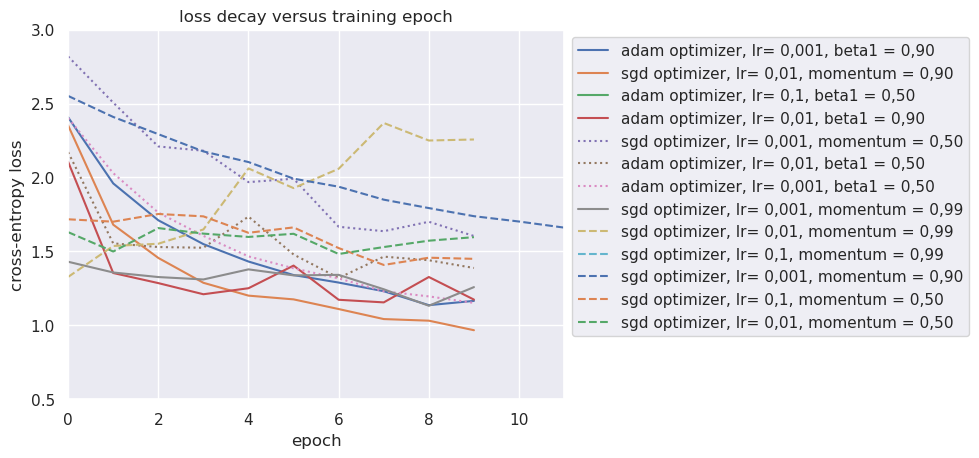

In [62]:
root_dir = 'models/losses/fc_layer_finetuning_only'
losses = os.listdir(root_dir)
sns.set()

#for each file in root dir
i = 0 #counter of curves
for loss in losses:
    optim = loss.split('_')[0] #read optimizer name
    lr = loss.split('_')[2][:-2] #read learning rate
    param = loss.split('_')[1][4:] #read parameter and value
    param_val = loss.split('_')[1][:4] 

    path = os.path.join(root_dir, loss)

    #depending on how many curves we already have on the plot, change line style
    if i > 3 and i < 7:
        style = 'dotted'
    elif i > 7:
        style = 'dashed'
    else:
        style = 'solid'


    #read the losses
    with open(path, 'rb') as picklefile:

        loss_list = pickle.load(picklefile)
        
        #plot the losses
        plt.plot(loss_list, 
                 label = '{} optimizer, lr= {}, {} = {}'.format(optim, lr, param, param_val),
                 linestyle = style)
    i += 1

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')
plt.ylim(0.5,3)
plt.xlim(0,11)
plt.title('loss decay versus training epoch')
plt.show()


The loss decay seems suboptimal. The best model so far reaches a loss of 1.0 after 10 epochs, which looks like a slow decay. It seems that freezing the whole model, and only retrining the weights of the last fc layer is not sufficient to make the model adapt to our dataset. In the next notebook, we will try to identify which layers should be finetubed on our dataset, in addition to our last fc layer, to optimize model training